# Mean climate evaluation

This analysis compares the mean climate of downscaled and parent models to observations. It doesn't consider extremes (i.e. the tails of the distribution aren't considered).

In [1]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import spatial_selection
import plotting
import time_utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dask.diagnostics.ProgressBar().register()

In [4]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [5]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

## AGCD data

In [6]:
agcd_years = np.arange(1995, 2015, 1)
agcd_tmax_files = [f'/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_{year}.nc' for year in agcd_years]
agcd_tmax_files

['/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1995.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1996.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1997.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1998.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_1999.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_2000.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_2001.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_2002.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_2003.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_2004.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_2005.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_t

In [7]:
agcd_ds = xr.open_mfdataset(agcd_tmax_files)
agcd_ds = agcd_ds.sel({'time': slice(start_date, end_date)})

In [8]:
agcd_ds

<xarray.Dataset>
Dimensions:    (time: 240, lat: 691, lon: 886, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-16 ... 2014-12-16
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Dimensions without coordinates: nv
Data variables:
    lat_bnds   (time, lat, nv) float32 dask.array<chunksize=(12, 691, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 dask.array<chunksize=(12, 886, 2), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    tmax       (time, lat, lon) float32 dask.array<chunksize=(12, 691, 886), meta=np.ndarray>
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1995-01-01T00:00:00
    date_created:              2018-11-27T04:27:00.649796
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-02 09:15:40
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:

In [9]:
agcd_monthly_clim = agcd_ds.groupby('time.month').mean('time', keep_attrs=True)

In [10]:
agcd_annual = time_utils.temporal_aggregation(agcd_ds, 'A', 'mean', ['tmax'], input_freq='M')
agcd_annual_clim = agcd_annual.mean('time', keep_attrs=True)

In [11]:
agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)

[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  3.5s


In [12]:
agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)

[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  3.5s


## Parent data

In [13]:
parent_files = {}
parent_files['NorESM2-MM'] = [
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc',
]
parent_files['ACCESS-CM2'] = [
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-CM2_historical_r4i1p1f1_gn_19500101-19991231.nc',
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-CM2_historical_r4i1p1f1_gn_20000101-20141231.nc'
]

In [14]:
def read_model_tasmax_data(file_list, obs_ds, aus_shape, time_bounds=None):
    """Read model tasmax data and calculate annual and monthly climatology"""
    
    ds = xr.open_mfdataset(file_list)
    input_units = ds['tasmax'].attrs['units']
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    try:
        ds = ds.drop('height')
    except ValueError:
        pass
    
    annual_clim = ds.mean('time', keep_attrs=True)
    monthly_clim = ds.groupby('time.month').mean('time', keep_attrs=True)

    if 'K' in input_units:
        print(f'Convert units from {input_units} to C')
        annual_clim['tasmax'] = annual_clim['tasmax'] - 273.13
        monthly_clim['tasmax'] = monthly_clim['tasmax'] - 273.13
        annual_clim['tasmax'].attrs['units'] = 'C'
        monthly_clim['tasmax'].attrs['units'] = 'C'
    
    regridder = xe.Regridder(ds, obs_ds, "bilinear")
    annual_clim = regridder(annual_clim)
    monthly_clim = regridder(monthly_clim)
    
    annual_clim = spatial_selection.select_shapefile_regions(annual_clim, aus_shape)
    monthly_clim = spatial_selection.select_shapefile_regions(monthly_clim, aus_shape)
    
    annual_clim = annual_clim.compute()
    monthly_clim = monthly_clim.compute()
    
    return monthly_clim, annual_clim

In [15]:
annual_clim_dict = {}
monthly_clim_dict = {}

for model in ['NorESM2-MM', 'ACCESS-CM2']:
    monthly_clim_dict[model], annual_clim_dict[model] = read_model_tasmax_data(
        parent_files[model], agcd_ds, aus_shape, time_bounds=[start_date, end_date],
    )

Convert units from K to C
[########################################] | 100% Completed | 19.7s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.4s
Convert units from K to C
[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.7s


## RCM data

In [16]:
rcm_files = {}

rcm_files['BARPA'] = glob.glob('/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/*.nc')
rcm_files['BARPA'].sort()
rcm_files['BARPA']

['/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19800101-19801231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19810101-19811231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19820101-19821231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19830101-19831231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1

In [17]:
for model in ['BARPA']:
    monthly_clim_dict[model], annual_clim_dict[model] = read_model_tasmax_data(
        rcm_files[model], agcd_ds, aus_shape,
    )

Convert units from K to C
[########################################] | 100% Completed |  1min  0.4s
[########################################] | 100% Completed | 31.3s
[########################################] | 100% Completed | 31.0s
[########################################] | 100% Completed | 30.3s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.6s


## Mean bias

In [18]:
agcd_annual_clim = agcd_annual_clim.compute()

[########################################] | 100% Completed |  3.8s


/g/data/xv83/dbi599/model-evaluation/tasmax_annual-clim_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


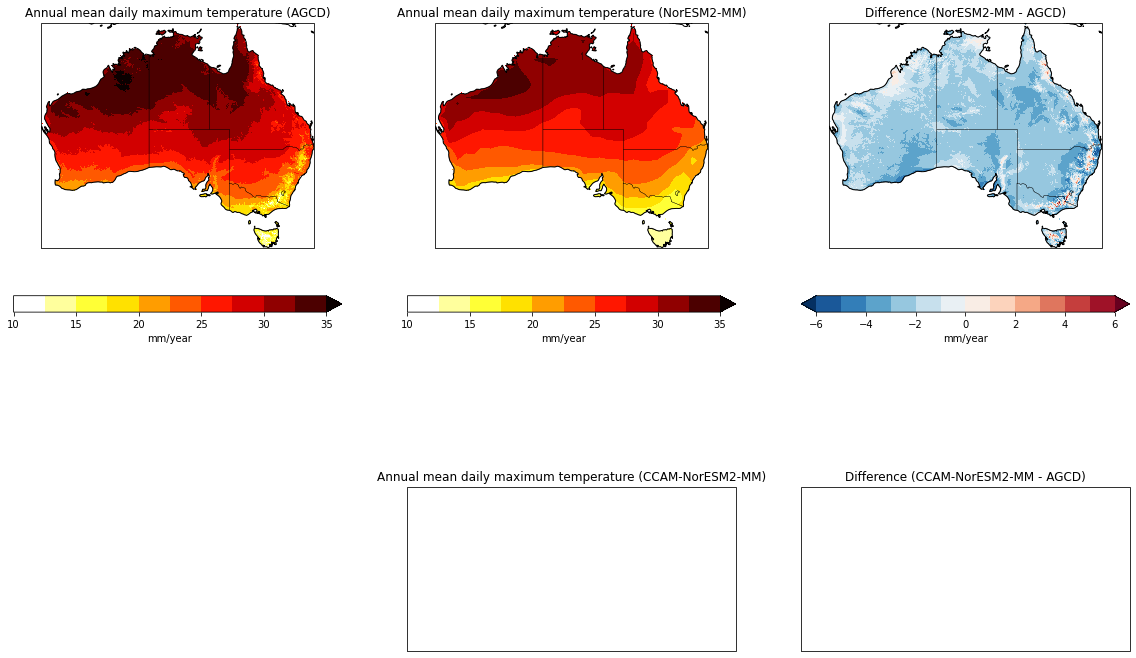

In [19]:
plotting.compare_agcd_gcm_rcm(
    agcd_annual_clim['tmax'],
    annual_clim_dict['NorESM2-MM']['tasmax'],
    'tasmax',
    'annual-clim',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
    [10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30.0, 32.5, 35.0],
    [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6],
    rcm_da=None,
)

/g/data/xv83/dbi599/model-evaluation/tasmax_annual-clim_BARPA-ACCESS-CM2_1995-01-01_2014-12-31.png


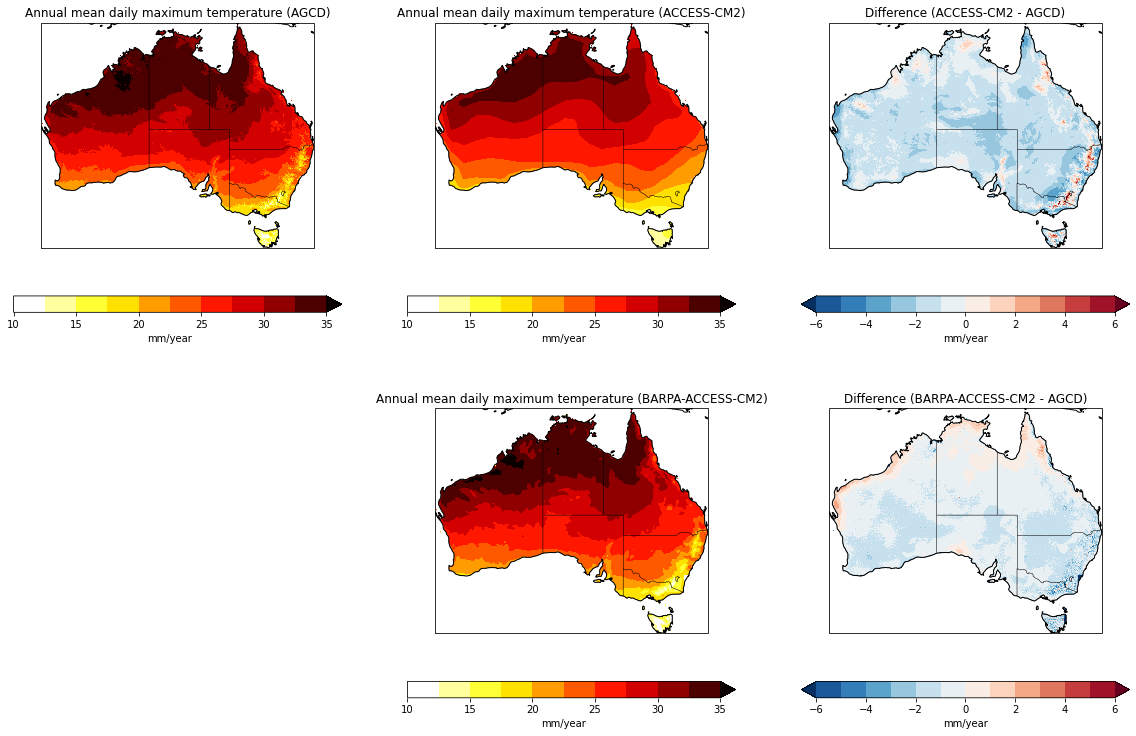

In [20]:
plotting.compare_agcd_gcm_rcm(
    agcd_annual_clim['tmax'],
    annual_clim_dict['ACCESS-CM2']['tasmax'],
    'tasmax',
    'annual-clim',
    'ACCESS-CM2',
    'BARPA',
    start_date,
    end_date,
    [10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30.0, 32.5, 35.0],
    [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6],
    rcm_da=annual_clim_dict['BARPA']['tasmax'],
)

## Temporal 

[                                        ] | 0% Completed |  0.0s

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[########################################] | 100% Completed |  4.2s


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  3.7s


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/g/data/xv83/dbi599/model-evaluation/tasmax_seasonal-cycle_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


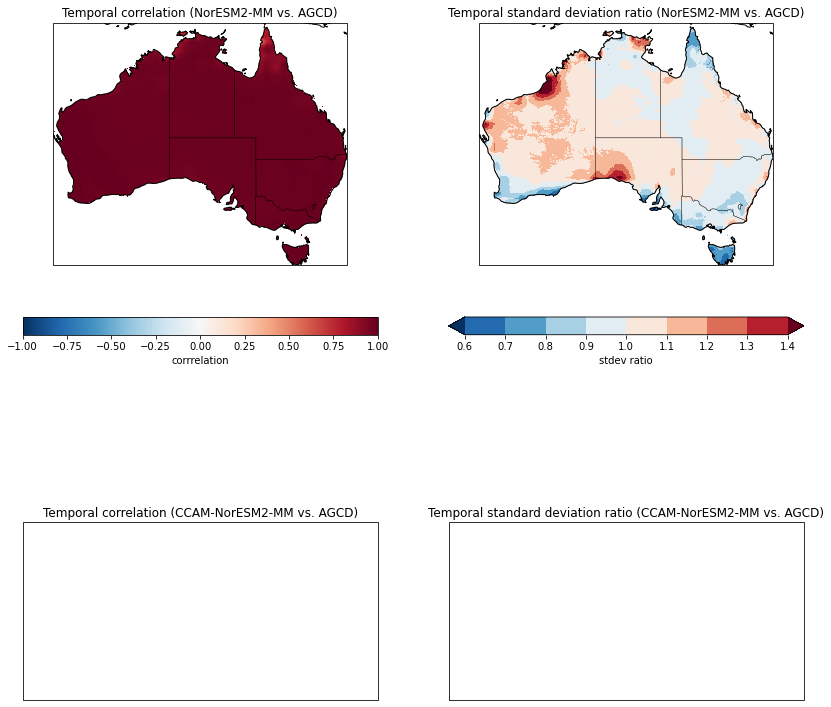

In [21]:
plotting.temporal_evaluation(
    monthly_clim_dict['NorESM2-MM']['tasmax'],
    agcd_monthly_clim['tmax'],
    'tasmax',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
    std_ratio_levels=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
)

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[                                        ] | 0% Completed |  0.1s

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[########################################] | 100% Completed |  4.1s


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  3.7s


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4.1s


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  3.7s


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/g/data/xv83/dbi599/model-evaluation/tasmax_seasonal-cycle_BARPA-ACCESS-CM2_1995-01-01_2014-12-31.png


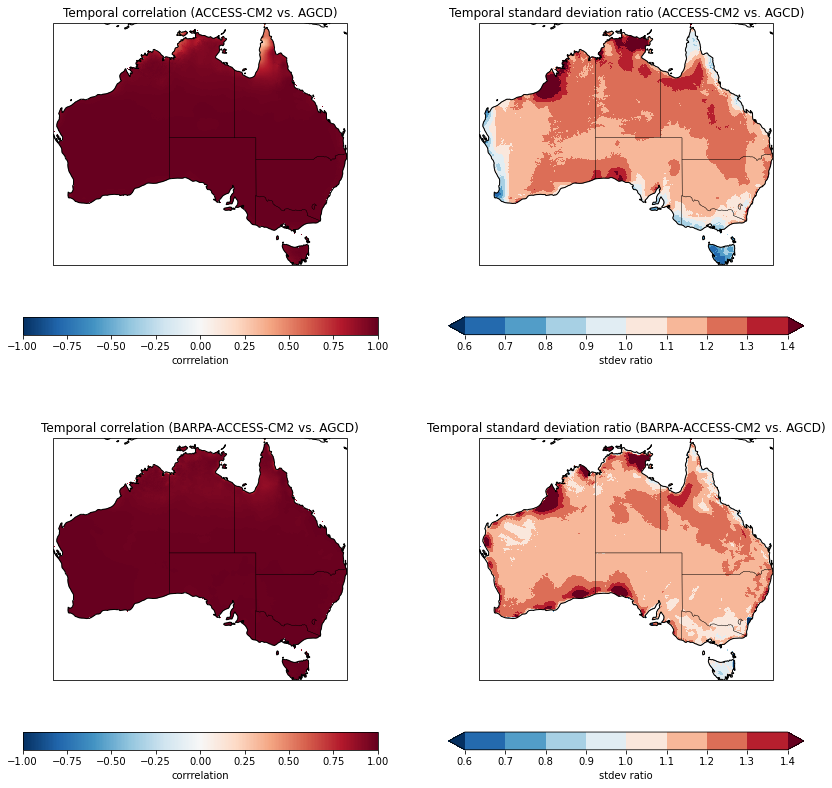

In [22]:
plotting.temporal_evaluation(
    monthly_clim_dict['ACCESS-CM2']['tasmax'],
    agcd_monthly_clim['tmax'],
    'tasmax',
    'ACCESS-CM2',
    'BARPA',
    start_date,
    end_date,
    rcm_monthly_clim=monthly_clim_dict['BARPA']['tasmax'],
    std_ratio_levels=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
)

[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.7s


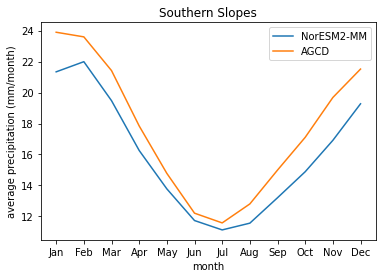

In [23]:
plotting.seasonal_cycle(
    monthly_clim_dict['NorESM2-MM']['tasmax'],
    agcd_monthly_clim['tmax'],
    'NorESM2-MM',
    cluster_name='Southern Slopes'
)